In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [3]:
meta = pd.read_csv('body_users.csv')

segment = pd.read_csv('user_segment_slice.csv')
segment.date = pd.to_datetime(segment.date)
segment.sort_values('date', inplace=True)

events_files = glob('users_events*.csv')
events = pd.concat((pd.read_csv(f) for f in events_files))
events['date_mod'] = pd.to_datetime(events['date_mod'])
events.sort_values('date_mod', inplace=True)

In [4]:

# ---------------------------
# 1) Map raw events -> canonical steps (regexes; safe to extend)
# ---------------------------
STEP_PATTERNS = {
    1: [
        r'^Account successfully created for user$',
        r'^Account setup completed successfully$'
    ],
    2: [
        r'^Initiated account registration$',
        r'^Account set up through a mobile device$'
    ],
    3: [
        r'^User session established$',
        r'^User profile status changed$'
    ],
    4: [
        r'^Chosen a pricing plan for the accoun'  # note: source string is truncated 'accoun'
    ],
    5: [
        r'^Unable to create account$',
        r'^Account opened successfully$',
        r'^Switched to live environment$',
        r'^Account registered under a personal name$',
        r'^Account created for a business or organization$'
    ],
}

# Pre-compile
STEP_REGEX = [(step, re.compile("|".join(pats), flags=re.IGNORECASE)) for step, pats in STEP_PATTERNS.items()]

def map_step(name: str) -> float:
    if pd.isna(name):
        return np.nan
    for step, cregex in STEP_REGEX:
        if cregex.search(str(name).strip()):
            return step
    return np.nan

# ---------------------------
# 2) Keep only onboarding events and add step_no
# ---------------------------
events['step_no'] = events['name'].map(map_step)
onb = events.loc[events['step_no'].notna(), ['user_id', 'name', 'date_mod', 'step_no']].copy()
onb['step_no'] = onb['step_no'].astype('Int64')

In [5]:

# ---------------------------
# 3) Build attempts per user
#    - Every occurrence of step 1 starts a new attempt (+1)
#    - Users who start at step>1 will have attempt 0 for those early rows
# ---------------------------
onb = onb.sort_values(['user_id', 'date_mod'])
onb['is_new_attempt'] = ((onb['step_no'] == 1).astype(int))
onb['attempt'] = onb.groupby('user_id')['is_new_attempt'].cumsum()

In [6]:

# Optional: treat a new step-1 appearing > X days after a completed attempt as a new attempt anyway (already handled).
# If you want a timeout-based split even without step-1, you could add a gap rule.

# ---------------------------
# 4) Collapse to one row per user_id × attempt with earliest ts per step
# ---------------------------
first_ts_per_step = (
    onb.groupby(['user_id', 'attempt', 'step_no'], as_index=False)['date_mod']
       .min()
       .rename(columns={'date_mod': 'step_ts'})
)

funnel = (
    first_ts_per_step
      .pivot(index=['user_id', 'attempt'], columns='step_no', values='step_ts')
      .rename(columns={1: 'step_1_ts', 2:'step_2_ts', 3:'step_3_ts', 4:'step_4_ts', 5:'step_5_ts'})
      .reset_index()
)

# First seen step timestamp (useful when step_1 is missing)
funnel['first_seen_ts'] = funnel[['step_1_ts','step_2_ts','step_3_ts','step_4_ts','step_5_ts']].min(axis=1)

# Completion flags (two flavors)
funnel['completed_any_step5'] = funnel['step_5_ts'].notna()
# If you want "strict linear" completion (saw 1->2->3->4->5 in non-decreasing order):
def strict_completed(row):
    seq = [row['step_1_ts'], row['step_2_ts'], row['step_3_ts'], row['step_4_ts'], row['step_5_ts']]
    if any(pd.isna(x) for x in seq):
        return False
    return seq == sorted(seq)
funnel['completed_strict'] = funnel.apply(strict_completed, axis=1)

# Time-to-complete (two baselines)
funnel['ttc_from_step1_hours'] = (funnel['step_5_ts'] - funnel['step_1_ts']).dt.total_seconds() / 3600
funnel['ttc_from_first_seen_hours'] = (funnel['step_5_ts'] - funnel['first_seen_ts']).dt.total_seconds() / 3600

# Highest step reached (1..5)
def highest_step(row):
    return max([s for s, ts in enumerate([None, row['step_1_ts'], row['step_2_ts'], row['step_3_ts'], row['step_4_ts'], row['step_5_ts']]) if s>0 and pd.notna(ts)], default=np.nan)
funnel['max_step'] = funnel.apply(highest_step, axis=1)

In [7]:

# ---------------------------
# 5) Join attributes (channel/sex/age) from meta
#     - events.user_id == meta.id (per your note)
# ---------------------------
attrs = meta[['id','sex_type','age_segment','Канал привлечения','acquisition_channel_lvl_2','acquisition_channel_lvl_3']].copy()
attrs = attrs.drop_duplicates('id')
funnel = funnel.merge(attrs, left_on='user_id', right_on='id', how='left')
funnel.drop(columns=['id'], inplace=True)

In [8]:

# ---------------------------
# 6) Aggregate: completion + time-to-complete by channel/sex/age
# ---------------------------
def agg_block(df, label):
    out = df.groupby(label).agg(
        n_attempts=('user_id','count'),
        n_completed_any=('completed_any_step5','sum'),
        n_completed_strict=('completed_strict','sum'),
        completion_rate_any=('completed_any_step5','mean'),
        completion_rate_strict=('completed_strict','mean'),
        median_ttc_h_from_step1=('ttc_from_step1_hours', lambda x: np.nanmedian(x)),
        median_ttc_h_from_first=('ttc_from_first_seen_hours', lambda x: np.nanmedian(x)),
    ).sort_values('n_attempts', ascending=False).reset_index()
    return out

by_channel_lvl1 = agg_block(funnel, 'Канал привлечения')
by_channel_lvl2 = agg_block(funnel, 'acquisition_channel_lvl_2')
by_channel_lvl3 = agg_block(funnel, 'acquisition_channel_lvl_3')
by_sex = agg_block(funnel, 'sex_type')
by_age = agg_block(funnel, 'age_segment')

# Display top lines
print(by_channel_lvl1.head(10))
print(by_channel_lvl2.head(10))
print(by_channel_lvl3.head(10))
print(by_sex)
print(by_age)

  Канал привлечения  n_attempts  n_completed_any  n_completed_strict  \
0          Органика       90869            60689               24548   
1      Маркетинг KZ       41951            28468               11016   
2   Рефералка Sales       10265             6804                  79   

   completion_rate_any  completion_rate_strict  median_ttc_h_from_step1  \
0             0.667874                0.270147                 0.187993   
1             0.678601                0.262592                 0.183753   
2             0.662835                0.007696                 0.014340   

   median_ttc_h_from_first  
0                 0.001652  
1                 0.001570  
2                 0.001635  
  acquisition_channel_lvl_2  n_attempts  n_completed_any  n_completed_strict  \
0                  Органика       90869            60689               24548   
1        Рекламные Кабинеты       29732            20043                8573   
2           Рефералка Sales       10265             68

/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/1257533945.py:11: RuntimeWarning: All-NaN slice encountered
  median_ttc_h_from_step1=('ttc_from_step1_hours', lambda x: np.nanmedian(x)),
/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/1257533945.py:11: RuntimeWarning: All-NaN slice encountered
  median_ttc_h_from_step1=('ttc_from_step1_hours', lambda x: np.nanmedian(x)),
/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/1257533945.py:12: RuntimeWarning: All-NaN slice encountered
  median_ttc_h_from_first=('ttc_from_first_seen_hours', lambda x: np.nanmedian(x)),


In [9]:

# ---------------------------
# 7) Stepwise funnel rates (overall and by a chosen dimension)
# ---------------------------
def stepwise_rates(df):
    """Return count reached each step and % of attempts that reached the step."""
    cols = ['step_1_ts','step_2_ts','step_3_ts','step_4_ts','step_5_ts']
    reached = {c: df[c].notna().sum() for c in cols}
    total = len(df)
    pct = {c: reached[c]/total if total>0 else np.nan for c in cols}
    order = ['step_1_ts','step_2_ts','step_3_ts','step_4_ts','step_5_ts']
    return (pd.DataFrame({'reached': [reached[c] for c in order],
                          'pct_of_attempts': [pct[c] for c in order]},
                         index=[1,2,3,4,5])
              .rename_axis('step')
              .reset_index())

overall_funnel = stepwise_rates(funnel)
print(overall_funnel)

   step  reached  pct_of_attempts
0     1   470556         0.841473
1     2   237770         0.425193
2     3   181059         0.323779
3     4   103446         0.184988
4     5   104233         0.186395


In [10]:

# Example: top 5 channels by attempts
top_ch = by_channel_lvl1.nlargest(5, 'n_attempts')['Канал привлечения'].tolist()
stepwise_by_channel = {}
for ch in top_ch:
    stepwise_by_channel[ch] = stepwise_rates(funnel[funnel['Канал привлечения']==ch])

In [11]:

# ---------------------------
# 8) (Optional) Simple proportion tests: completion rate differences
# ---------------------------
from statsmodels.stats.proportion import proportions_ztest

def compare_two_groups(df, group_col, g1, g2, metric_col='completed_any_step5'):
    a = df[df[group_col]==g1][metric_col].dropna().astype(int)
    b = df[df[group_col]==g2][metric_col].dropna().astype(int)
    count = np.array([a.sum(), b.sum()])
    nobs = np.array([a.size, b.size])
    stat, p = proportions_ztest(count, nobs)
    return {'group_1': g1, 'group_2': g2, 'rate_1': a.mean(), 'rate_2': b.mean(), 'z': stat, 'p_value': p}

# Example: best vs worst channel by completion rate (among big channels)
big = by_channel_lvl1[by_channel_lvl1['n_attempts'] >= 1000].copy()
if not big.empty:
    best = big.sort_values('completion_rate_any', ascending=False).iloc[0]['Канал привлечения']
    worst = big.sort_values('completion_rate_any', ascending=True).iloc[0]['Канал привлечения']
    print(compare_two_groups(funnel, 'Канал привлечения', best, worst))


{'group_1': 'Маркетинг KZ', 'group_2': 'Рефералка Sales', 'rate_1': np.float64(0.6786012252389693), 'rate_2': np.float64(0.6628348757915246), 'z': np.float64(3.0581625759415156), 'p_value': np.float64(0.0022269872082578738)}


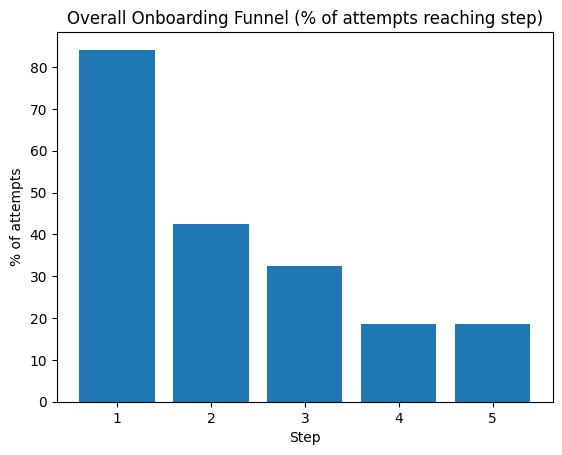

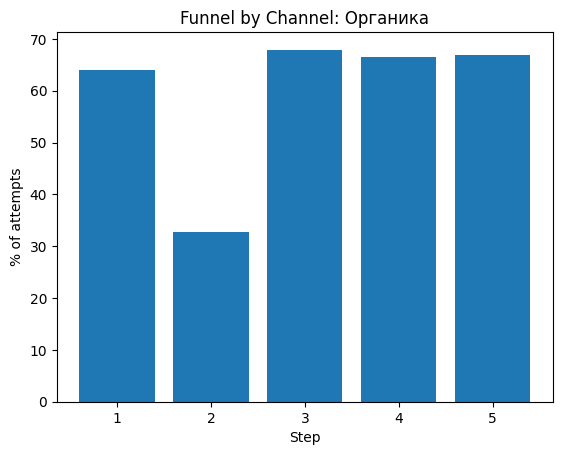

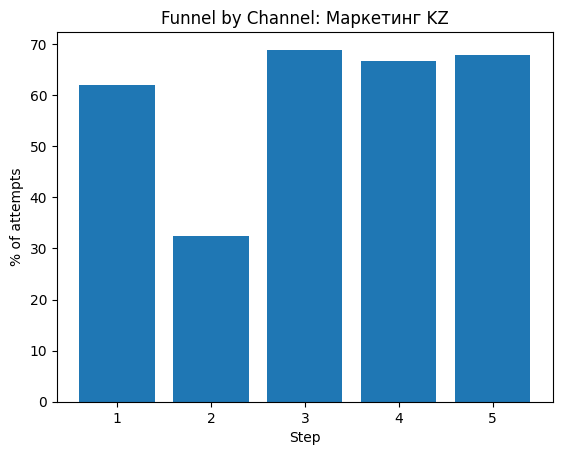

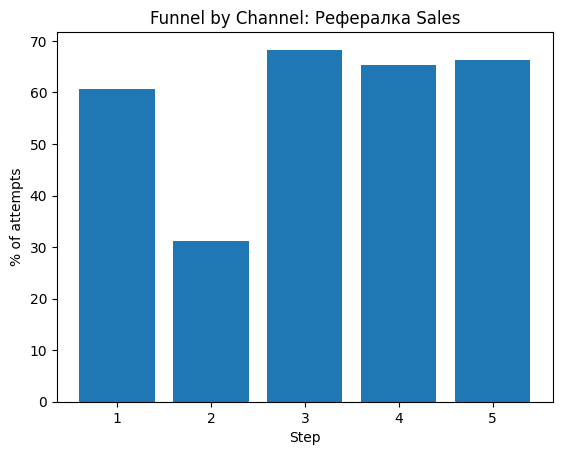

In [12]:

# ---------------------------
# 9) Plots (matplotlib only; no seaborn)
# ---------------------------
# Overall funnel bar (percent of attempts reaching each step)
plt.figure()
plt.bar(overall_funnel['step'].astype(str), overall_funnel['pct_of_attempts']*100)
plt.title('Overall Onboarding Funnel (% of attempts reaching step)')
plt.xlabel('Step')
plt.ylabel('% of attempts')
plt.show()

# Stepwise by top channels (one chart per channel)
for ch in top_ch:
    dfc = stepwise_by_channel[ch]
    plt.figure()
    plt.bar(dfc['step'].astype(str), dfc['pct_of_attempts']*100)
    plt.title(f'Funnel by Channel: {ch}')
    plt.xlabel('Step')
    plt.ylabel('% of attempts')
    plt.show()


# Next

In [13]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# ---------------------------
# 0) Canonical events & tokens
# ---------------------------
TOKEN_MAP = {
    'Account successfully created for user': 'CREATED',
    'Account setup completed successfully': 'SETUP_DONE',
    'Initiated account registration': 'REG_INIT',
    'Account set up through a mobile device': 'REG_MOBILE',
    'User session established': 'SESSION',
    'User profile status changed': 'PROFILE_STATUS',
    'Chosen a pricing plan for the accoun': 'PRICING',  # source string is truncated in your data
    'Unable to create account': 'OPEN_FAIL',
    'Account opened successfully': 'OPEN_OK',
    'Switched to live environment': 'SWITCH_LIVE',
    'Account registered under a personal name': 'REG_PERSONAL',
    'Account created for a business or organization': 'REG_BUSINESS',
}

CANONICAL = set(TOKEN_MAP.keys())

# start triggers (loose)
START_EVENTS = {
    'Account successfully created for user',
    'Account setup completed successfully',
    'Initiated account registration',
    'Account set up through a mobile device',
}

# terminal success/failure (for splitting attempts & labeling)
SUCCESS_EVENTS = {'Account opened successfully', 'Switched to live environment'}
FAIL_EVENTS = {'Unable to create account'}
TERMINAL_EVENTS = SUCCESS_EVENTS | FAIL_EVENTS

# ---------------------------
# 1) Filter to canonical onboarding events
# ---------------------------
e = events[events['name'].isin(CANONICAL)].copy()
e = e.sort_values(['user_id', 'date_mod'])

# Attach tokens
e['token'] = e['name'].map(TOKEN_MAP)

# ---------------------------
# 2) Attempt segmentation rules
#    New attempt if:
#      - we hit a start event, OR
#      - gap since previous event for user > GAP_H, OR
#      - previous attempt ended in terminal success/fail and activity resumes
# ---------------------------
GAP_H = 24  # adjust if you like

e['gap_h'] = e.groupby('user_id')['date_mod'].diff().dt.total_seconds().div(3600)
e['is_start'] = e['name'].isin(START_EVENTS)
e['is_success_evt'] = e['name'].isin(SUCCESS_EVENTS)
e['is_fail_evt'] = e['name'].isin(FAIL_EVENTS)
e['is_terminal_evt'] = e['is_success_evt'] | e['is_fail_evt']
e['prev_terminal'] = e.groupby('user_id')['is_terminal_evt'].shift().fillna(False)

e['new_attempt_flag'] = e['is_start'] | e['prev_terminal'] | (e['gap_h'] > GAP_H)
e['attempt'] = e.groupby('user_id')['new_attempt_flag'].cumsum().astype(int)

# ---------------------------
# 3) Build sequences per attempt
# ---------------------------
def dedupe_consecutive(seq):
    out = []
    last = object()
    for s in seq:
        if s != last:
            out.append(s)
            last = s
    return out

def unique_in_order(seq):
    seen = set()
    out = []
    for s in seq:
        if s not in seen:
            out.append(s)
            seen.add(s)
    return out

grp = e.groupby(['user_id','attempt'])
attempts = grp.agg(
    start_ts=('date_mod','min'),
    end_ts=('date_mod','max'),
    events_full=('token', list),
    names_full=('name', list),
    any_success=('is_success_evt','any'),
    any_fail=('is_fail_evt','any'),
    channel=('user_id', 'size')  # placeholder to keep groupby structure
).drop(columns='channel').reset_index()

# Variant signatures:
# - consecutive-deduped (removes spammy repeats)
# - unique-in-order (keeps only first occurrence of each event within attempt)
attempts['events_no_dupes'] = attempts['events_full'].apply(dedupe_consecutive)
attempts['events_unique_order'] = attempts['events_full'].apply(unique_in_order)

def seq_to_str(seq): 
    return " > ".join(seq)

attempts['variant_nodupes'] = attempts['events_no_dupes'].apply(seq_to_str)
attempts['variant_unique']  = attempts['events_unique_order'].apply(seq_to_str)

# Success label for the attempt
attempts['success'] = attempts['any_success'].astype(bool)
attempts['failure'] = attempts['any_fail'].astype(bool)

# Time-to-success if successful
attempts['ttc_hours'] = np.where(
    attempts['success'],
    (attempts['end_ts'] - attempts['start_ts']).dt.total_seconds() / 3600.0,
    np.nan
)

# ---------------------------
# 4) Join attributes (channel/sex/age) from meta
# ---------------------------
attrs = meta[['id','sex_type','age_segment','Канал привлечения',
              'acquisition_channel_lvl_2','acquisition_channel_lvl_3']].drop_duplicates('id')
attempts = attempts.merge(attrs, left_on='user_id', right_on='id', how='left').drop(columns=['id'])

# ---------------------------
# 5) Top variants (overall & by channel)
# ---------------------------
def top_variants(df, variant_col='variant_unique', top_n=20, min_count=50):
    tmp = (df.groupby(variant_col)
             .agg(n_attempts=('user_id','count'),
                  success_rate=('success','mean'),
                  median_ttc_h=('ttc_hours', lambda x: np.nanmedian(x)))
             .sort_values('n_attempts', ascending=False)
             .reset_index())
    tmp = tmp[tmp['n_attempts'] >= min_count]
    return tmp.head(top_n)

top_overall = top_variants(attempts, 'variant_unique')
print("\n=== Top overall variants (unique-in-order) ===")
print(top_overall)

/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/87423284.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  e['prev_terminal'] = e.groupby('user_id')['is_terminal_evt'].shift().fillna(False)



=== Top overall variants (unique-in-order) ===
                                     variant_unique  n_attempts  success_rate  \
0                                         OPEN_FAIL     1239594           0.0   
1                                           CREATED      235278           0.0   
2                                        SETUP_DONE      228431           0.0   
3                                        REG_MOBILE      140243           0.0   
4                                          REG_INIT      136225           0.0   
5                         REG_INIT > PROFILE_STATUS       93791           0.0   
6                             SESSION > SWITCH_LIVE       78187           1.0   
7                                 PRICING > OPEN_OK       48276           1.0   
8   REG_MOBILE > PROFILE_STATUS > PRICING > OPEN_OK       31907           1.0   
9                                           SESSION       27307           0.0   
10                                      SWITCH_LIVE       177

/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/87423284.py:136: RuntimeWarning: All-NaN slice encountered
  median_ttc_h=('ttc_hours', lambda x: np.nanmedian(x)))


In [14]:

# Example: by top channels
top_channels = (attempts['Канал привлечения']
                .value_counts().head(3).index.tolist())

top_by_channel = {}
for ch in top_channels:
    top_by_channel[ch] = top_variants(
        attempts[attempts['Канал привлечения']==ch], 
        'variant_unique', top_n=15, min_count=30
    )
    print(f"\n=== Top variants for channel: {ch} ===")
    print(top_by_channel[ch])


=== Top variants for channel: Органика ===
                                     variant_unique  n_attempts  success_rate  \
0                                         OPEN_FAIL      234349           0.0   
1                             SESSION > SWITCH_LIVE       51003           1.0   
2                                        REG_MOBILE       36260           0.0   
3                                 PRICING > OPEN_OK       30405           1.0   
4                                           CREATED       29063           0.0   
5                                        SETUP_DONE       28904           0.0   
6                         REG_INIT > PROFILE_STATUS       28563           0.0   
7   REG_MOBILE > PROFILE_STATUS > PRICING > OPEN_OK       20528           1.0   
8                                       SWITCH_LIVE        9571           1.0   
9                PROFILE_STATUS > PRICING > OPEN_OK        8710           1.0   
10                           REG_MOBILE > OPEN_FAIL        2981  

/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/87423284.py:136: RuntimeWarning: All-NaN slice encountered
  median_ttc_h=('ttc_hours', lambda x: np.nanmedian(x)))
/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/87423284.py:136: RuntimeWarning: All-NaN slice encountered
  median_ttc_h=('ttc_hours', lambda x: np.nanmedian(x)))
/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/87423284.py:136: RuntimeWarning: All-NaN slice encountered
  median_ttc_h=('ttc_hours', lambda x: np.nanmedian(x)))


In [15]:

# ---------------------------
# 6) Transition edges (process map / Markov)
#    For each attempt, generate edges between consecutive events (noduped),
#    then compute counts and eventual success rate for attempts that traverse the edge.
# ---------------------------
edges = []
for _, row in attempts.iterrows():
    seq = row['events_no_dupes']
    if len(seq) < 2:
        continue
    succ = bool(row['success'])
    for i in range(len(seq)-1):
        edges.append((seq[i], seq[i+1], succ, row['Канал привлечения']))

edges_df = pd.DataFrame(edges, columns=['src','dst','attempt_success','channel'])

edge_stats = (edges_df.groupby(['src','dst'])
              .agg(n=('attempt_success','size'),
                   success_rate=('attempt_success','mean'))
              .sort_values('n', ascending=False)
              .reset_index())

print("\n=== Top edges overall ===")
print(edge_stats.head(20))


=== Top edges overall ===
               src             dst      n  success_rate
0         REG_INIT  PROFILE_STATUS  93818      0.000149
1          PRICING         OPEN_OK  93662      1.000000
2          SESSION     SWITCH_LIVE  78190      1.000000
3   PROFILE_STATUS         PRICING  48242      0.947390
4       REG_MOBILE  PROFILE_STATUS  34230      0.938884
5       REG_MOBILE       OPEN_FAIL   8475      0.000000
6       SETUP_DONE  PROFILE_STATUS   6846      0.000000
7       REG_MOBILE    REG_PERSONAL   5444      0.001653
8          PRICING  PROFILE_STATUS   3530      0.099717
9       REG_MOBILE         PRICING   1716      0.018065
10  PROFILE_STATUS         OPEN_OK   1496      1.000000
11  PROFILE_STATUS       OPEN_FAIL    325      0.000000
12         PRICING       OPEN_FAIL    240      0.000000
13        REG_INIT         PRICING    226      0.044248
14    REG_PERSONAL       OPEN_FAIL    124      0.000000
15    REG_PERSONAL  PROFILE_STATUS    102      0.500000
16    REG_BUSINESS   

In [16]:

# per-channel edge stats (optional)
edge_stats_by_ch = (edges_df.groupby(['channel','src','dst'])
                    .agg(n=('attempt_success','size'),
                         success_rate=('attempt_success','mean'))
                    .reset_index())

# ---------------------------
# 7) Prefix analysis (tree-like view without building a heavy trie)
#    Count most common prefixes of length k, with success rates.
# ---------------------------
def top_prefixes(df, k=3, min_count=50):
    rows = []
    for _, r in df.iterrows():
        seq = r['events_no_dupes']
        succ = bool(r['success'])
        if len(seq) >= k:
            pref = tuple(seq[:k])
            rows.append((pref, succ))
    if not rows:
        return pd.DataFrame(columns=['prefix','n','success_rate'])
    x = pd.DataFrame(rows, columns=['prefix','succ'])
    out = (x.groupby('prefix')
             .agg(n=('succ','size'), success_rate=('succ','mean'))
             .sort_values('n', ascending=False)
             .reset_index())
    out = out[out['n'] >= min_count]
    out['prefix_str'] = out['prefix'].apply(lambda t: " > ".join(t))
    return out[['prefix_str','n','success_rate']]

for k in (2,3,4):
    print(f"\n=== Top prefixes length {k} (overall) ===")
    print(top_prefixes(attempts, k=k, min_count=50).head(15))


=== Top prefixes length 2 (overall) ===
                     prefix_str      n  success_rate
0     REG_INIT > PROFILE_STATUS  93818      0.000149
1         SESSION > SWITCH_LIVE  78187      1.000000
2             PRICING > OPEN_OK  48276      1.000000
3   REG_MOBILE > PROFILE_STATUS  34230      0.938884
4      PROFILE_STATUS > PRICING  14534      0.945094
5        REG_MOBILE > OPEN_FAIL   8475      0.000000
6   SETUP_DONE > PROFILE_STATUS   6846      0.000000
7     REG_MOBILE > REG_PERSONAL   5444      0.001653
8          REG_MOBILE > PRICING   1716      0.018065
9      PROFILE_STATUS > OPEN_OK    917      1.000000
10           REG_INIT > PRICING    226      0.044248
11          PRICING > OPEN_FAIL    221      0.000000
12   PROFILE_STATUS > OPEN_FAIL    170      0.000000
13     REG_PERSONAL > OPEN_FAIL    113      0.000000
14     PRICING > PROFILE_STATUS     94      0.074468

=== Top prefixes length 3 (overall) ===
                                  prefix_str      n  success_rate
0   

In [17]:

# ---------------------------
# 8) Channel/sex/age slices for sequence metrics
# ---------------------------
def seq_kpis(df):
    return (df.agg(
        n_attempts=('user_id','count'),
        success_rate=('success','mean'),
        median_ttc_h=('ttc_hours', lambda x: np.nanmedian(x))
    ).to_frame().T)

print("\n=== Sequence KPIs by channel ===")
print(attempts.groupby('Канал привлечения').apply(seq_kpis).droplevel(1).sort_values('n_attempts', ascending=False))

print("\n=== Sequence KPIs by sex ===")
print(attempts.groupby('sex_type').apply(seq_kpis).droplevel(1))

print("\n=== Sequence KPIs by age ===")
print(attempts.groupby('age_segment').apply(seq_kpis).droplevel(1).sort_values('n_attempts', ascending=False))



=== Sequence KPIs by channel ===


/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/1058484104.py:8: RuntimeWarning: All-NaN slice encountered
  median_ttc_h=('ttc_hours', lambda x: np.nanmedian(x))
/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/1058484104.py:5: FutureWarning: using <function seq_kpis.<locals>.<lambda> at 0x43828f4c0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  return (df.agg(


ValueError: Data must be 1-dimensional, got ndarray of shape (3, 1) instead

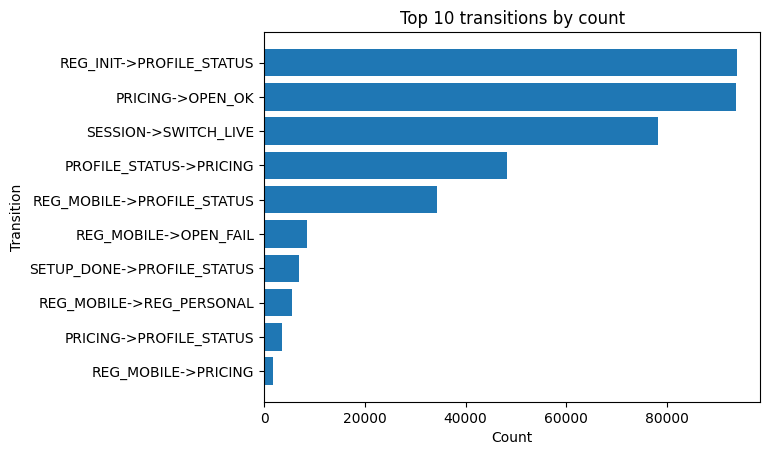

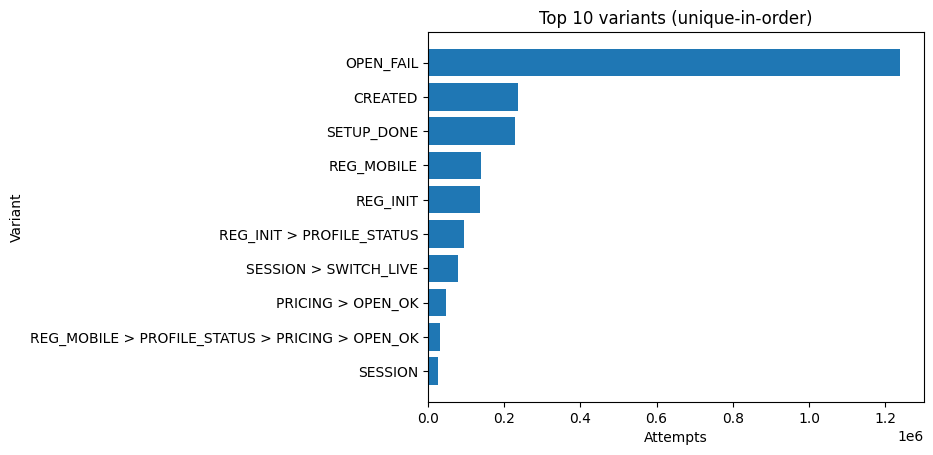

In [18]:

# ---------------------------
# 9) (Optional) Quick plots (matplotlib only)
# ---------------------------
# Top 10 edges by count
top10_edges = edge_stats.head(10)
plt.figure()
plt.barh([f"{s}->{d}" for s,d in zip(top10_edges['src'], top10_edges['dst'])], top10_edges['n'])
plt.title('Top 10 transitions by count')
plt.xlabel('Count'); plt.ylabel('Transition')
plt.gca().invert_yaxis()
plt.show()

# Variant frequency (top 10)
top10_vars = top_overall.head(10)
plt.figure()
plt.barh(top10_vars['variant_unique'], top10_vars['n_attempts'])
plt.title('Top 10 variants (unique-in-order)')
plt.xlabel('Attempts'); plt.ylabel('Variant')
plt.gca().invert_yaxis()
plt.show()

   step  reached  pct_of_attempts
0     1   470556         0.841473
1     2   237770         0.425193
2     3   181059         0.323779
3     4   103446         0.184988
4     5   104233         0.186395


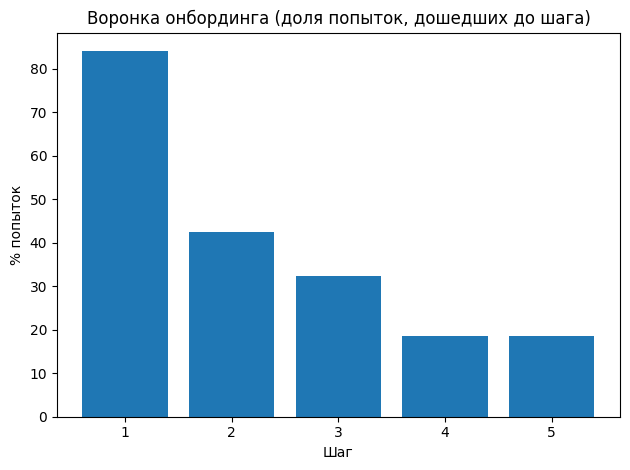

In [19]:
# If you don’t have `overall_funnel` from earlier, rebuild quickly:
cols = ['step_1_ts','step_2_ts','step_3_ts','step_4_ts','step_5_ts']
def stepwise_rates(df):
    reached = [df[c].notna().sum() for c in cols]
    total = len(df)
    pct = [r/total if total>0 else 0 for r in reached]
    return pd.DataFrame({'step':[1,2,3,4,5],'reached':reached,'pct_of_attempts':pct})

overall_funnel = stepwise_rates(funnel)
print(overall_funnel)

# Bar: % of attempts reaching each step
plt.figure()
plt.bar(overall_funnel['step'].astype(str), overall_funnel['pct_of_attempts']*100)
plt.title('Воронка онбординга (доля попыток, дошедших до шага)')
plt.xlabel('Шаг')
plt.ylabel('% попыток')
plt.tight_layout()
plt.show()

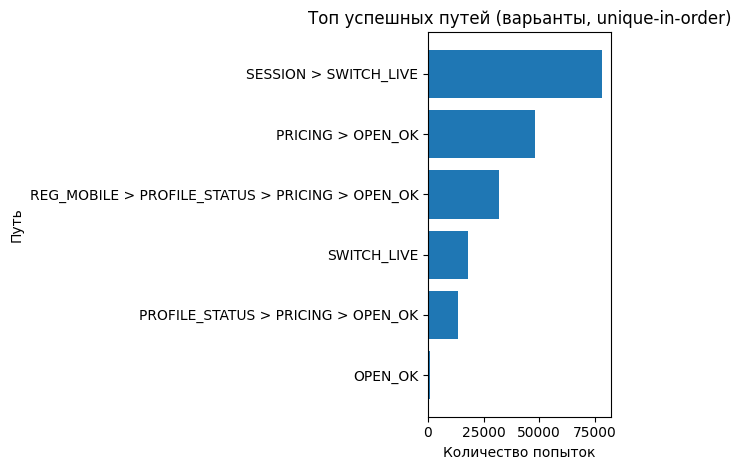

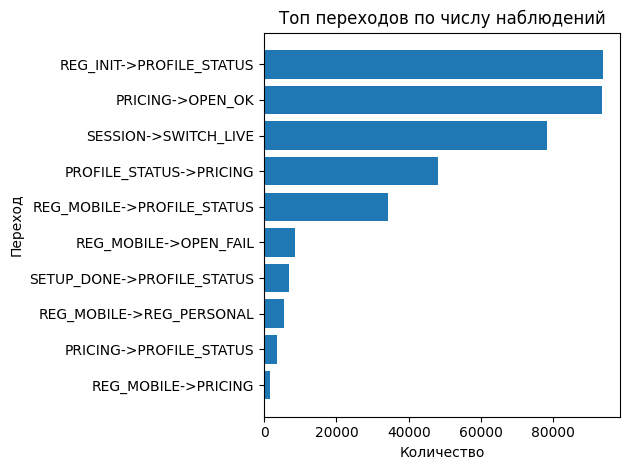

In [20]:
# Top successful variants (unique-in-order), already computed as `top_overall`
succ_vars = top_overall[top_overall['success_rate']>0].head(10)

plt.figure()
plt.barh(succ_vars['variant_unique'], succ_vars['n_attempts'])
plt.title('Топ успешных путей (варьанты, unique-in-order)')
plt.xlabel('Количество попыток')
plt.ylabel('Путь')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Top transitions (edges) by count
top10_edges = edge_stats.head(10)
plt.figure()
plt.barh([f"{s}->{d}" for s,d in zip(top10_edges['src'], top10_edges['dst'])], top10_edges['n'])
plt.title('Топ переходов по числу наблюдений')
plt.xlabel('Количество')
plt.ylabel('Переход')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

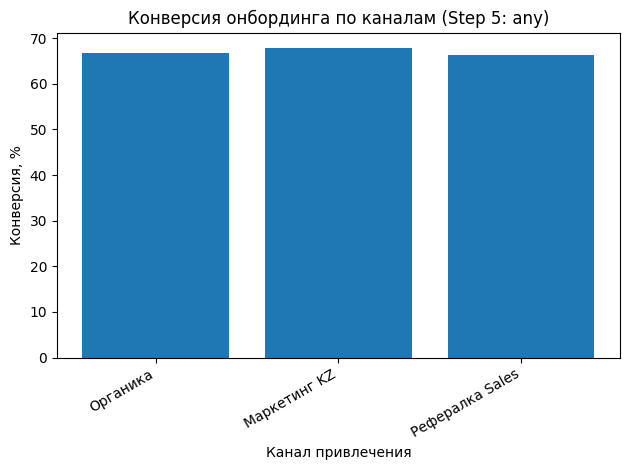

  Канал привлечения  n_attempts  success_rate  median_ttc_h
0          Органика      484032      0.250702      0.001053
1      Маркетинг KZ      225203      0.252883      0.001043
2   Рефералка Sales       91790      0.146922      0.001066


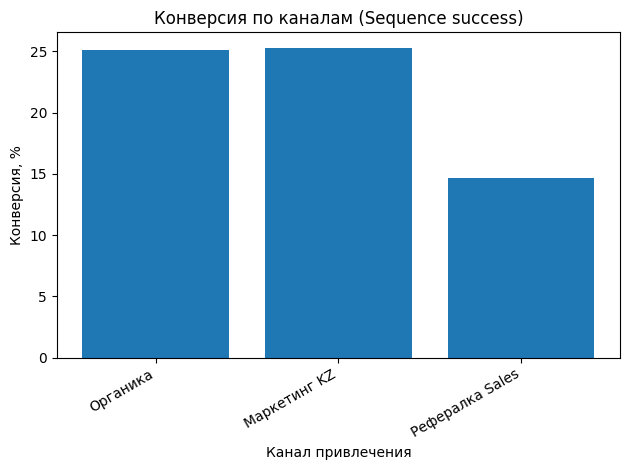

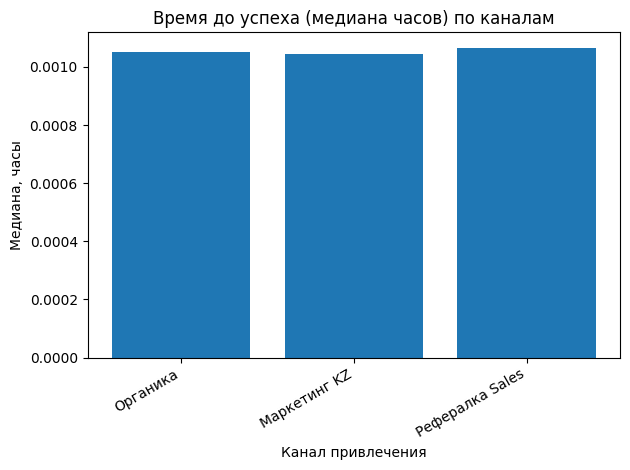

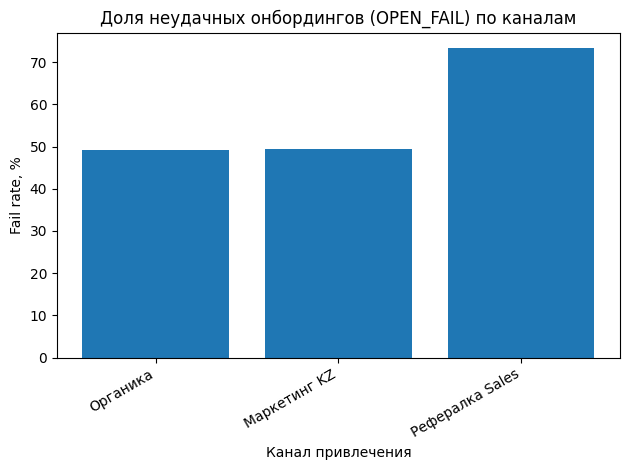

In [21]:
# 1) По классической воронке (any step-5)
by_ch = by_channel_lvl1.copy()

plt.figure()
topN = 10
top = by_ch.sort_values('n_attempts', ascending=False).head(topN)
plt.bar(top['Канал привлечения'], top['completion_rate_any']*100)
plt.title('Конверсия онбординга по каналам (Step 5: any)')
plt.xlabel('Канал привлечения')
plt.ylabel('Конверсия, %')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# 2) По последовательностям (sequence success_rate)
seq_kpis_ch = (attempts.groupby('Канал привлечения')
               .agg(n_attempts=('user_id','count'),
                    success_rate=('success','mean'),
                    median_ttc_h=('ttc_hours', lambda x: np.nanmedian(x)))
               .sort_values('n_attempts', ascending=False)
               .reset_index())

print(seq_kpis_ch.head(10))

plt.figure()
top_seq = seq_kpis_ch.head(topN)
plt.bar(top_seq['Канал привлечения'], top_seq['success_rate']*100)
plt.title('Конверсия по каналам (Sequence success)')
plt.xlabel('Канал привлечения')
plt.ylabel('Конверсия, %')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# 3) Время до успеха (медиана часов) — among successful attempts only
succ_only = attempts[attempts['success']].copy()
ttc_by_ch = (succ_only.groupby('Канал привлечения')
             .agg(n_success=('user_id','count'),
                  median_ttc_h=('ttc_hours', lambda x: np.nanmedian(x)))
             .sort_values('n_success', ascending=False)
             .reset_index())

plt.figure()
top_ttc = ttc_by_ch.head(topN)
plt.bar(top_ttc['Канал привлечения'], top_ttc['median_ttc_h'])
plt.title('Время до успеха (медиана часов) по каналам')
plt.xlabel('Канал привлечения')
plt.ylabel('Медиана, часы')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# 4) Доля фейла (OPEN_FAIL) среди попыток канала
fail_variant_mask = (attempts['variant_unique'] == 'OPEN_FAIL') | attempts['events_full'].apply(lambda L: 'OPEN_FAIL' in L if isinstance(L, list) else False)
fail_by_ch = (attempts.assign(fail=fail_variant_mask.astype(int))
              .groupby('Канал привлечения')
              .agg(n_attempts=('user_id','count'),
                   fail_rate=('fail','mean'))
              .sort_values('n_attempts', ascending=False)
              .reset_index())

plt.figure()
top_fail = fail_by_ch.head(topN)
plt.bar(top_fail['Канал привлечения'], top_fail['fail_rate']*100)
plt.title('Доля неудачных онбордингов (OPEN_FAIL) по каналам')
plt.xlabel('Канал привлечения')
plt.ylabel('Fail rate, %')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import numpy as np

# === 1. Список событий ровно как в задании ===
ONBOARDING_EVENTS = [
    'Account successfully created for user',
    'Account setup completed successfully',
    'Initiated account registration',
    'Account set up through a mobile device',
    'User session established',
    'User profile status changed',
    'Chosen a pricing plan for the accoun',
    'Unable to create account',
    'Account opened successfully',
    'Switched to live environment',
    'Account registered under a personal name',
    'Account created for a business or organization'
]

# метки успех/фейл
SUCCESS_EVENTS = {
    'Account opened successfully',
    'Switched to live environment',
    'Account registered under a personal name',
    'Account created for a business or organization'
}
FAIL_EVENTS = {'Unable to create account'}

# === 2. Оставляем только эти события ===
e = events[events['name'].isin(ONBOARDING_EVENTS)].copy()
e = e.sort_values(['user_id','date_mod'])

# === 3. Сегментация попыток ===
# Новая попытка, если мы видим одно из первых событий (1 или 2 группы)
START_EVENTS = {
    'Account successfully created for user',
    'Account setup completed successfully',
    'Initiated account registration',
    'Account set up through a mobile device'
}

e['gap_h'] = e.groupby('user_id')['date_mod'].diff().dt.total_seconds().div(3600)
e['prev_terminal'] = e.groupby('user_id')['name'].shift().isin(SUCCESS_EVENTS|FAIL_EVENTS).fillna(False)
e['new_attempt_flag'] = (
    e['name'].isin(START_EVENTS) |
    e['prev_terminal'] |
    (e['gap_h']>24)
)
e['attempt'] = e.groupby('user_id')['new_attempt_flag'].cumsum()

# === 4. Собираем последовательности по каждой попытке ===
grp = e.groupby(['user_id','attempt'])
attempts = grp.agg(
    start_ts=('date_mod','min'),
    end_ts=('date_mod','max'),
    events_full=('name', list),
    any_success=('name', lambda x: x.isin(SUCCESS_EVENTS).any()),
    any_fail=('name', lambda x: x.isin(FAIL_EVENTS).any())
).reset_index()

attempts['success'] = attempts['any_success']
attempts['failure'] = attempts['any_fail']
attempts['variant_str'] = attempts['events_full'].apply(lambda seq: ' > '.join(seq))
attempts['ttc_h'] = np.where(
    attempts['success'],
    (attempts['end_ts']-attempts['start_ts']).dt.total_seconds()/3600.0,
    np.nan
)

# === 5. Считаем топовые последовательности ===
top_variants = (attempts.groupby('variant_str')
                .agg(n_attempts=('user_id','count'),
                     success_rate=('success','mean'),
                     median_ttc_h=('ttc_h', lambda x: np.nanmedian(x)))
                .sort_values('n_attempts', ascending=False)
                .reset_index())
print(top_variants.head(20))

# === 6. Топовые переходы (пары событий) ===
edges = []
for _, row in attempts.iterrows():
    seq = row['events_full']
    succ = row['success']
    for i in range(len(seq)-1):
        edges.append((seq[i], seq[i+1], succ))
edges_df = pd.DataFrame(edges, columns=['src','dst','succ'])

edge_stats = (edges_df.groupby(['src','dst'])
              .agg(n=('succ','size'), success_rate=('succ','mean'))
              .sort_values('n', ascending=False)
              .reset_index())
print(edge_stats.head(20))

/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/1676821469.py:74: RuntimeWarning: All-NaN slice encountered
  median_ttc_h=('ttc_h', lambda x: np.nanmedian(x)))


                                          variant_str  n_attempts  \
0                            Unable to create account     1239720   
1               Account successfully created for user      235278   
2                Account setup completed successfully      228431   
3              Account set up through a mobile device      140243   
4                      Initiated account registration      136225   
5   Initiated account registration > User profile ...       93779   
6   Chosen a pricing plan for the accoun > Account...       48275   
7   User session established > Switched to live en...       43703   
8   Account set up through a mobile device > User ...       31765   
9   User session established > User session establ...       28171   
10                       Switched to live environment       17789   
11  User session established > User session establ...       17411   
12  User profile status changed > Chosen a pricing...       13510   
13  Account set up through a mobil

In [25]:
import numpy as np
import pandas as pd
from time import perf_counter

# OPTIONAL: progress bars for groupby-apply (we avoid apply though)
try:
    from tqdm.auto import tqdm
    tqdm.pandas()
except Exception:
    tqdm = None

tic = perf_counter()

# =========================
# 0) Config / mappings (EXACT event names)
# =========================
STEP_EVENTS = {
    1: [
        'Account successfully created for user',
        'Account setup completed successfully'
    ],
    2: [
        'Initiated account registration',
        'Account set up through a mobile device'
    ],
    3: [
        'User session established',
        'User profile status changed'
    ],
    4: [
        'Chosen a pricing plan for the accoun'
    ],
    5: [
        'Unable to create account',  # BAD
        'Account opened successfully',
        'Switched to live environment',
        'Account registered under a personal name',
        'Account created for a business or organization'
    ]
}
GOOD_OUTCOMES = {
    'Account opened successfully',
    'Switched to live environment',
    'Account registered under a personal name',
    'Account created for a business or organization'
}
BAD_OUTCOME = {'Unable to create account'}

ALLOWED_EVENT_NAMES = set().union(*STEP_EVENTS.values())
name_to_step = {name: step for step, names in STEP_EVENTS.items() for name in names}

print("[1/8] Filter & prep…")
ev = events.loc[events['name'].isin(ALLOWED_EVENT_NAMES), ['user_id','name','date_mod']].copy()
# Speed/memory tips:
ev['name'] = ev['name'].astype('category')
ev['step_no'] = ev['name'].map(name_to_step).astype('Int8')
ev = ev.sort_values(['user_id','date_mod'], kind='mergesort')  # stable, fast for grouped times

# =========================
# 1) Build attempts (vectorized)
# =========================
print("[2/8] Attempt segmentation…")
STARTISH_STEPS = {1,2,3}
GAP_H = 24

ev['gap_h'] = ev.groupby('user_id', sort=False)['date_mod'].diff().dt.total_seconds().div(3600)
ev['is_terminal'] = ev['name'].isin(GOOD_OUTCOMES | BAD_OUTCOME)
ev['prev_terminal'] = ev.groupby('user_id', sort=False)['is_terminal'].shift().fillna(False)
ev['new_attempt_flag'] = (
    ev['step_no'].isin(STARTISH_STEPS) |
    ev['prev_terminal'] |
    (ev['gap_h'] > GAP_H)
)
# cumulative sum per user → attempt id
ev['attempt'] = ev.groupby('user_id', sort=False)['new_attempt_flag'].cumsum().astype('int32')

# =========================
# 2) Per-attempt core timestamps (vectorized)
# =========================
print("[3/8] Per-attempt timestamps…")
# Start timestamp
start_ts = ev.groupby(['user_id','attempt'], sort=False)['date_mod'].min().rename('start_ts')

# Earliest timestamp per step (wide pivot)
step_first = (
    ev.groupby(['user_id','attempt','step_no'], sort=False)['date_mod']
      .min()
      .unstack('step_no')  # columns = step_no
      .rename(columns={1:'step_1_ts',2:'step_2_ts',3:'step_3_ts',4:'step_4_ts',5:'step_5_ts'})
)

# =========================
# 3) Outcomes & outcome timestamps (vectorized)
# =========================
print("[4/8] Outcomes…")
is_good = ev['name'].isin(GOOD_OUTCOMES)
is_bad  = ev['name'].isin(BAD_OUTCOME)

good_ts = ev.loc[is_good].groupby(['user_id','attempt'], sort=False)['date_mod'].min().rename('good_ts')
bad_ts  = ev.loc[is_bad].groupby(['user_id','attempt'],  sort=False)['date_mod'].min().rename('bad_ts')

# Assemble attempt frame
attempts2 = (
    pd.concat([start_ts, step_first, good_ts, bad_ts], axis=1)
      .reset_index()
)

# Flags
attempts2['good_outcome'] = attempts2['good_ts'].notna()
attempts2['bad_outcome']  = attempts2['bad_ts'].notna()
attempts2['outcome'] = np.where(attempts2['good_outcome'], 'success',
                         np.where(attempts2['bad_outcome'], 'fail', 'none'))

# Outcome timestamp & ttc (no loops)
attempts2['outcome_ts'] = attempts2['good_ts'].fillna(attempts2['bad_ts'])
attempts2['ttc_h'] = (attempts2['outcome_ts'] - attempts2['start_ts']).dt.total_seconds().div(3600)

# Entry step = smallest step with non-null ts
print("[5/8] Entry-step calc…")
step_cols = ['step_1_ts','step_2_ts','step_3_ts','step_4_ts','step_5_ts']
mask = attempts2[step_cols].notna().values
# Argmin of first True along axis=1; if none True → 5, we’ll set to NaN later
first_idx = mask.argmax(axis=1)
# If a row had all False, argmax returns 0; fix with any()
any_reached = mask.any(axis=1)
entry_step = np.where(any_reached, first_idx+1, np.nan)
attempts2['entry_step'] = entry_step.astype('float32')

# =========================
# 4) Specific good types (vectorized)
# =========================
print("[6/8] Specific good outcomes…")
# Build flags quickly using groupby.any on boolean masks
def grp_any(mask):
    return ev.loc[mask].groupby(['user_id','attempt'], sort=False).size().rename('tmp')

open_ok_mask      = ev['name'].eq('Account opened successfully')
switch_live_mask  = ev['name'].eq('Switched to live environment')
reg_personal_mask = ev['name'].eq('Account registered under a personal name')
reg_business_mask = ev['name'].eq('Account created for a business or organization')

# Convert to presence by aligning indices
def presence_from_mask(mask, colname):
    s = ev.loc[mask, ['user_id','attempt']].assign(v=1).drop_duplicates().set_index(['user_id','attempt'])['v']
    return s.rename(colname)

presence = []
for m, cname in [
    (open_ok_mask, 'open_ok'),
    (switch_live_mask, 'switch_live'),
    (reg_personal_mask, 'reg_personal'),
    (reg_business_mask, 'reg_business')
]:
    presence.append(presence_from_mask(m, cname))

presence_df = pd.concat(presence, axis=1)
attempts2 = attempts2.merge(presence_df, on=['user_id','attempt'], how='left')
attempts2[['open_ok','switch_live','reg_personal','reg_business']] = \
    attempts2[['open_ok','switch_live','reg_personal','reg_business']].fillna(0).astype('uint8')

# =========================
# 5) Join attributes & KPIs (vectorized)
# =========================
print("[7/8] KPIs…")
attrs = meta[['id','sex_type','age_segment','Канал привлечения',
              'acquisition_channel_lvl_2','acquisition_channel_lvl_3']].drop_duplicates('id')
attempts2 = attempts2.merge(attrs, left_on='user_id', right_on='id', how='left').drop(columns=['id'])

# Attempt-level KPIs by channel
attempt_kpis_ch = (attempts2.groupby('Канал привлечения', sort=False)
    .agg(n_attempts=('user_id','size'),
         success_rate_any=('good_outcome','mean'),
         open_ok_rate=('open_ok','mean'),
         bad_rate=('bad_outcome','mean'),
         median_ttc_h=('ttc_h', lambda x: np.nanmedian(x)))
    .sort_values('n_attempts', ascending=False)
    .reset_index()
)

# User-level KPIs by channel (ever succeeded)
user_level = (attempts2.groupby(['user_id','Канал привлечения'], sort=False)
    .agg(any_good=('good_outcome','any'),
         any_open_ok=('open_ok', lambda x: (x>0).any()),
         any_bad=('bad_outcome','any'))
    .reset_index()
)

user_kpis_ch = (user_level.groupby('Канал привлечения', sort=False)
    .agg(n_users=('user_id','nunique'),
         users_any_good=('any_good','sum'),
         users_open_ok=('any_open_ok','sum'),
         users_any_bad=('any_bad','sum'))
    .reset_index()
)
user_kpis_ch['user_conv_any_good'] = user_kpis_ch['users_any_good'] / user_kpis_ch['n_users']
user_kpis_ch['user_conv_open_ok']  = user_kpis_ch['users_open_ok'] / user_kpis_ch['n_users']
user_kpis_ch['user_bad_share']     = user_kpis_ch['users_any_bad'] / user_kpis_ch['n_users']

# Entry-step distribution
entry_dist = (attempts2.assign(entry_step_cat=attempts2['entry_step'].fillna(0).astype('int8'))
              .groupby(['Канал привлечения','entry_step_cat'], sort=False)
              .size().rename('n_attempts').reset_index())
totals = entry_dist.groupby('Канал привлечения', sort=False)['n_attempts'].sum().rename('total').reset_index()
entry_dist = entry_dist.merge(totals, on='Канал привлечения', how='left')
entry_dist['share'] = entry_dist['n_attempts'] / entry_dist['total']

# Order-agnostic step reach
step_reach = (attempts2.assign(
                    r1=attempts2['step_1_ts'].notna(),
                    r2=attempts2['step_2_ts'].notna(),
                    r3=attempts2['step_3_ts'].notna(),
                    r4=attempts2['step_4_ts'].notna(),
                    r5=attempts2['step_5_ts'].notna())
              [['r1','r2','r3','r4','r5']].mean().rename(index={'r1':1,'r2':2,'r3':3,'r4':4,'r5':5}))
overall_step = step_reach.reset_index().rename(columns={'index':'step',0:'share_reached'})

print("[8/8] Done in {:.1f}s".format(perf_counter()-tic))

# Peek results
print("\n=== Attempt-level (by channel) ===")
print(attempt_kpis_ch.head(10))
print("\n=== User-level (by channel) ===")
print(user_kpis_ch.head(10))
print("\n=== Entry-step (head) ===")
print(entry_dist.head(10))
print("\n=== Order-agnostic step reach ===")
print(overall_step)

[1/8] Filter & prep…
[2/8] Attempt segmentation…


/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/1275637628.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ev['prev_terminal'] = ev.groupby('user_id', sort=False)['is_terminal'].shift().fillna(False)


[3/8] Per-attempt timestamps…
[4/8] Outcomes…
[5/8] Entry-step calc…
[6/8] Specific good outcomes…
[7/8] KPIs…
[8/8] Done in 6.5s

=== Attempt-level (by channel) ===
  Канал привлечения  n_attempts  success_rate_any  open_ok_rate  bad_rate  \
0          Органика      565570          0.215080      0.107449  0.419884   
1      Маркетинг KZ      259373          0.220817      0.110008  0.429867   
2   Рефералка Sales      103765          0.157192      0.065080  0.648677   

   median_ttc_h  
0           0.0  
1           0.0  
2           0.0  

=== User-level (by channel) ===
  Канал привлечения  n_users  users_any_good  users_open_ok  users_any_bad  \
0          Органика    61801           60583          60576           4060   
1   Рефералка Sales     7100            6799           6733           1110   
2      Маркетинг KZ    28954           28427          28418           1841   

   user_conv_any_good  user_conv_open_ok  user_bad_share  
0            0.980292           0.980178        

In [26]:
# First event per attempt
first_evt = ev.groupby(['user_id','attempt'], sort=False).first().reset_index()[['user_id','attempt','name','step_no']]
attempts2 = attempts2.merge(first_evt, on=['user_id','attempt'], how='left', suffixes=('','_first'))

# Entry step 5 breakdown
attempts2['entry5_good'] = (attempts2['entry_step'] == 5) & attempts2['good_outcome'] & (attempts2['start_ts'] == attempts2['outcome_ts'])
attempts2['entry5_bad']  = (attempts2['entry_step'] == 5) & attempts2['bad_outcome']  & (attempts2['start_ts'] == attempts2['outcome_ts'])

entry5_by_ch = (attempts2.groupby('Канал привлечения')
    .agg(n_attempts=('user_id','size'),
         entry5_share=('entry_step', lambda s: (s==5).mean()),
         entry5_good_share=('entry5_good','mean'),
         entry5_bad_share=('entry5_bad','mean'))
    .reset_index())
print(entry5_by_ch.sort_values('n_attempts', ascending=False).head(10))

# Observability score: attempts with >= 2 distinct steps logged
distinct_steps = (ev.groupby(['user_id','attempt'], sort=False)['step_no']
                    .nunique().rename('n_steps').reset_index())
attempts2 = attempts2.merge(distinct_steps, on=['user_id','attempt'], how='left')
obs_by_ch = (attempts2.groupby('Канал привлечения')
    .agg(obs_share=('n_steps', lambda x: (x.fillna(0)>=2).mean()))
    .reset_index())
print(obs_by_ch.sort_values('obs_share', ascending=False))

  Канал привлечения  n_attempts  entry5_share  entry5_good_share  \
1          Органика      565570      0.432634           0.018217   
0      Маркетинг KZ      259373      0.452059           0.027347   
2   Рефералка Sales      103765      0.655443           0.015593   

   entry5_bad_share  
1          0.414417  
0          0.424713  
2          0.639850  
  Канал привлечения  obs_share
1          Органика   0.203941
0      Маркетинг KZ   0.200391
2   Рефералка Sales   0.152103


In [27]:
succ = attempts2[attempts2['good_outcome']].copy()
succ['ttc_s'] = (attempts2['outcome_ts'] - attempts2['start_ts']).dt.total_seconds()
p90_ttc = (succ.groupby('Канал привлечения')
           .agg(n_success=('user_id','count'),
                p50_s=('ttc_s', lambda x: np.nanpercentile(x, 50)),
                p90_s=('ttc_s', lambda x: np.nanpercentile(x, 90)))
           .sort_values('n_success', ascending=False))
print(p90_ttc.head(10))

                   n_success  p50_s   p90_s
Канал привлечения                          
Органика              121643  3.790  7.1560
Маркетинг KZ           57274  3.756  7.0667
Рефералка Sales        16311  3.950  7.0710


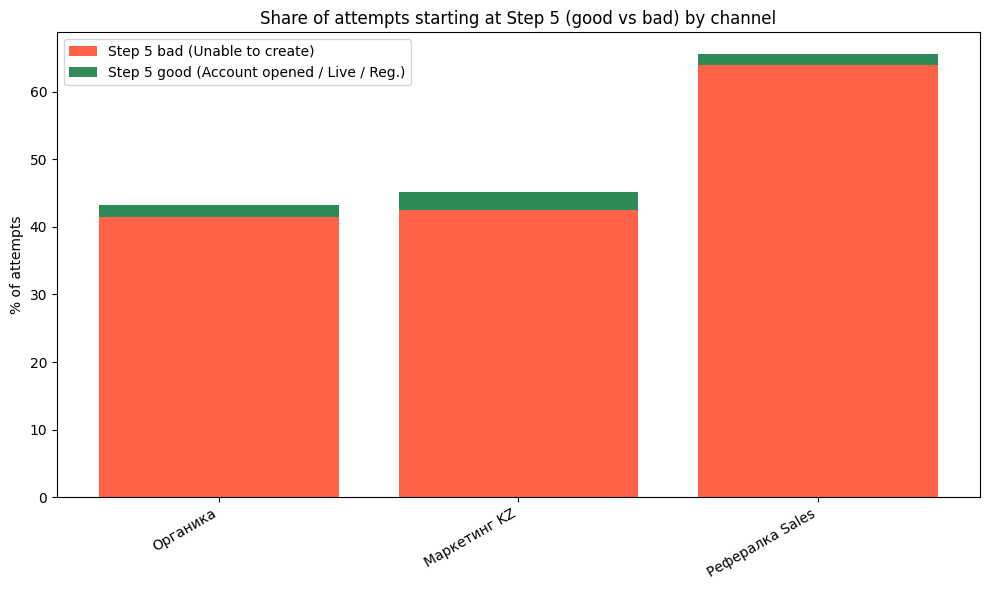

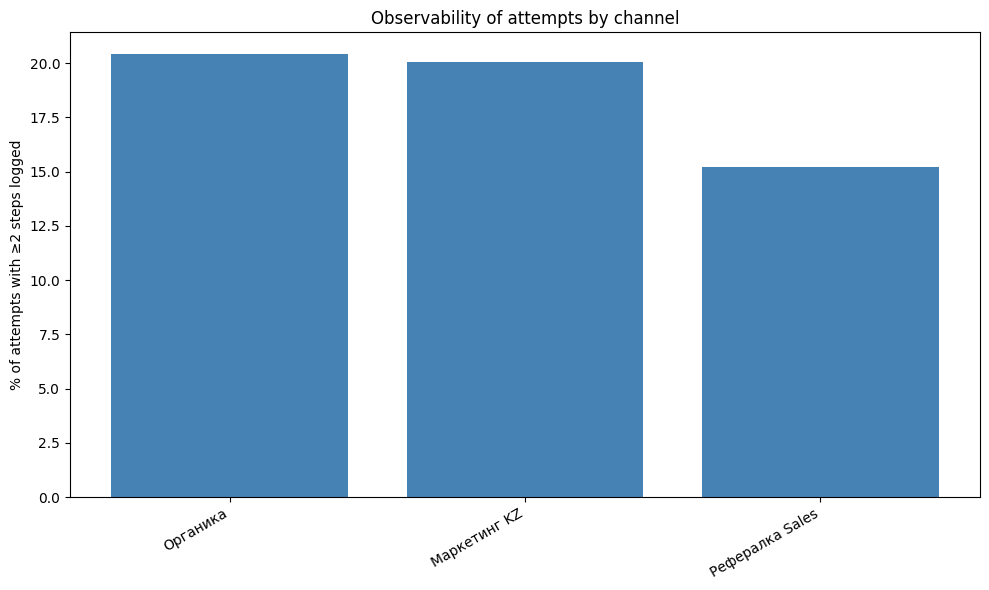

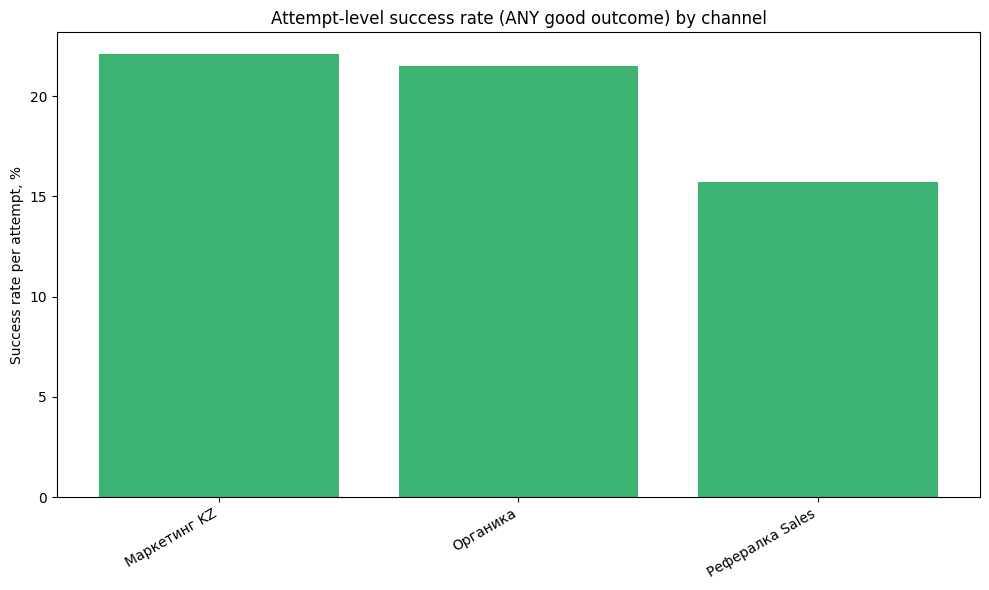

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Entry at step 5: good vs bad shares ---
# we already have entry5_by_ch with entry5_share, entry5_good_share, entry5_bad_share
entry_plot = entry5_by_ch.copy().sort_values('n_attempts', ascending=False)

plt.figure(figsize=(10,6))
bar_width = 0.4
x = np.arange(len(entry_plot))
plt.bar(x, entry_plot['entry5_bad_share']*100, label='Step 5 bad (Unable to create)', color='tomato')
plt.bar(x, entry_plot['entry5_good_share']*100, bottom=entry_plot['entry5_bad_share']*100,
        label='Step 5 good (Account opened / Live / Reg.)', color='seagreen')
plt.xticks(x, entry_plot['Канал привлечения'], rotation=30, ha='right')
plt.ylabel('% of attempts')
plt.title('Share of attempts starting at Step 5 (good vs bad) by channel')
plt.legend()
plt.tight_layout()
plt.show()

# --- 2) Observability (≥2 distinct steps logged) ---
obs_plot = obs_by_ch.copy().sort_values('obs_share', ascending=False)
plt.figure(figsize=(10,6))
plt.bar(obs_plot['Канал привлечения'], obs_plot['obs_share']*100, color='steelblue')
plt.xticks(rotation=30, ha='right')
plt.ylabel('% of attempts with ≥2 steps logged')
plt.title('Observability of attempts by channel')
plt.tight_layout()
plt.show()

# --- 3) Attempt-level success rate by channel ---
att_plot = attempt_kpis_ch.copy().sort_values('success_rate_any', ascending=False)
plt.figure(figsize=(10,6))
plt.bar(att_plot['Канал привлечения'], att_plot['success_rate_any']*100, color='mediumseagreen')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Success rate per attempt, %')
plt.title('Attempt-level success rate (ANY good outcome) by channel')
plt.tight_layout()
plt.show()

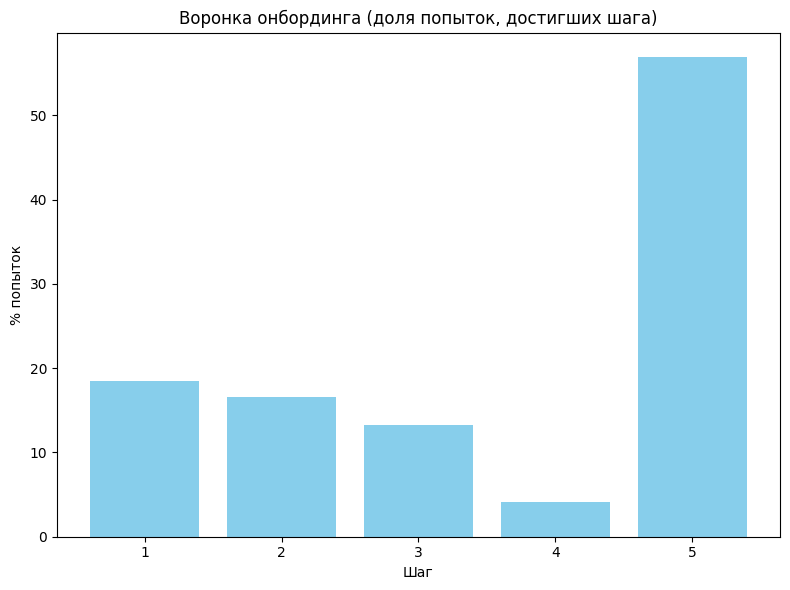

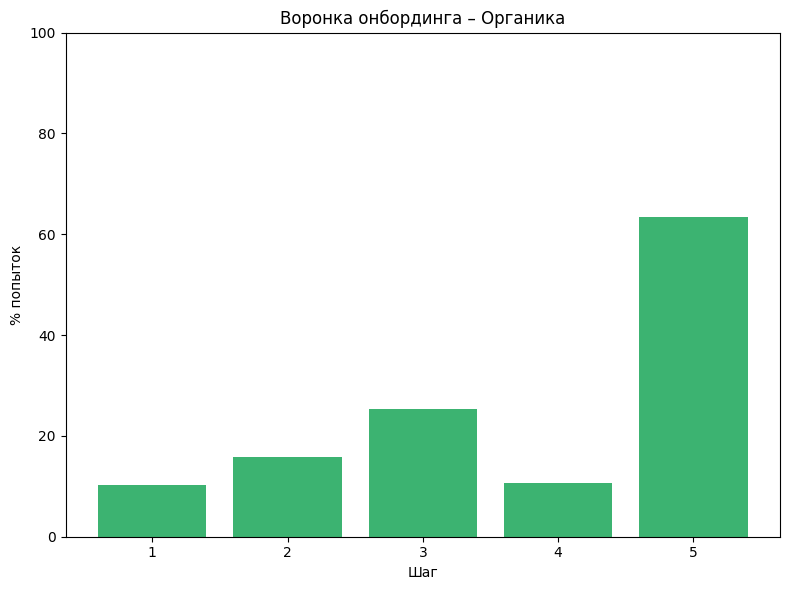

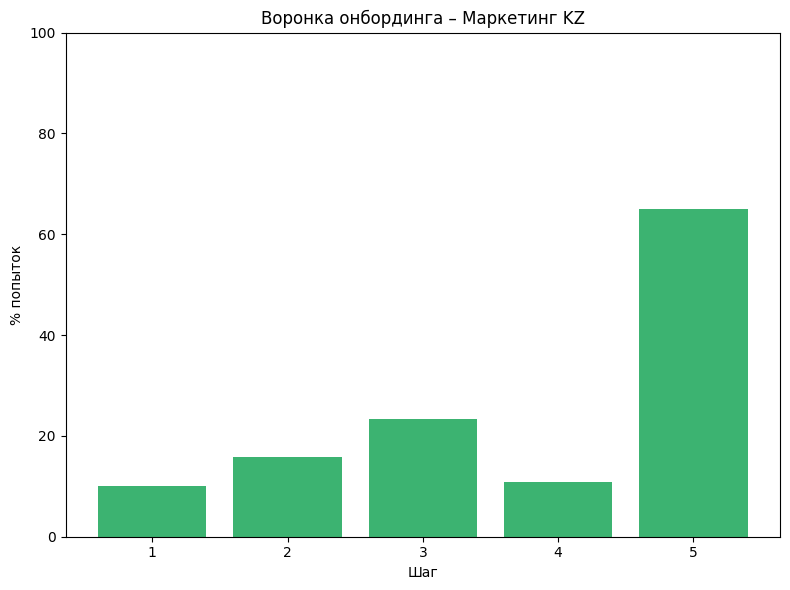

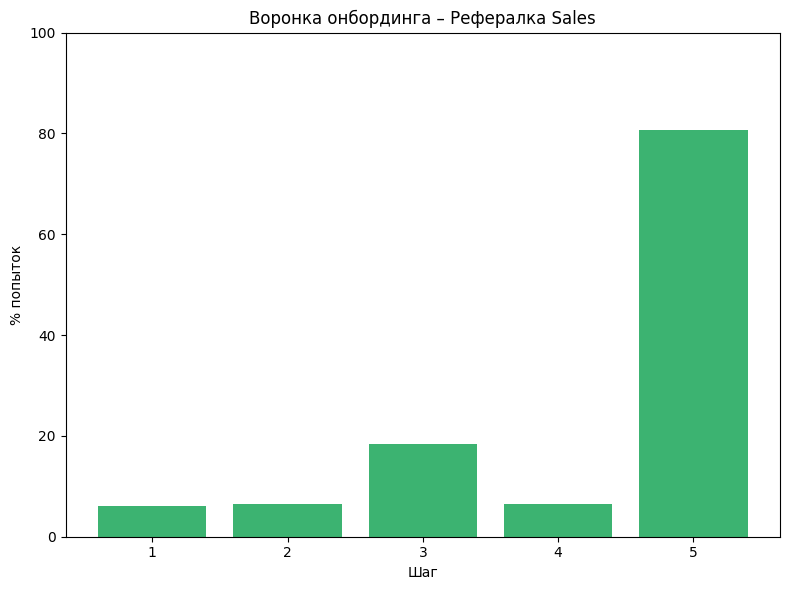

In [29]:
# --- Overall funnel (order-agnostic) ---
overall_funnel = (
    attempts2.assign(
        r1=attempts2['step_1_ts'].notna(),
        r2=attempts2['step_2_ts'].notna(),
        r3=attempts2['step_3_ts'].notna(),
        r4=attempts2['step_4_ts'].notna(),
        r5=attempts2['step_5_ts'].notna())
    [['r1','r2','r3','r4','r5']]
    .mean().rename(index={'r1':1,'r2':2,'r3':3,'r4':4,'r5':5})
    .reset_index().rename(columns={'index':'step',0:'share'}))

plt.figure(figsize=(8,6))
plt.bar(overall_funnel['step'].astype(str), overall_funnel['share']*100, color='skyblue')
plt.title('Воронка онбординга (доля попыток, достигших шага)')
plt.xlabel('Шаг')
plt.ylabel('% попыток')
plt.tight_layout()
plt.show()

# --- Funnel by channel for top N channels ---
topN = 3
top_channels = attempt_kpis_ch.sort_values('n_attempts', ascending=False)['Канал привлечения'].head(topN).tolist()

for ch in top_channels:
    sub = attempts2[attempts2['Канал привлечения']==ch]
    funnel_ch = (
        sub.assign(
            r1=sub['step_1_ts'].notna(),
            r2=sub['step_2_ts'].notna(),
            r3=sub['step_3_ts'].notna(),
            r4=sub['step_4_ts'].notna(),
            r5=sub['step_5_ts'].notna())
        [['r1','r2','r3','r4','r5']]
        .mean().rename(index={'r1':1,'r2':2,'r3':3,'r4':4,'r5':5})
        .reset_index().rename(columns={'index':'step',0:'share'}))
    
    plt.figure(figsize=(8,6))
    plt.bar(funnel_ch['step'].astype(str), funnel_ch['share']*100, color='mediumseagreen')
    plt.title(f'Воронка онбординга – {ch}')
    plt.xlabel('Шаг')
    plt.ylabel('% попыток')
    plt.ylim(0,100)
    plt.tight_layout()
    plt.show()

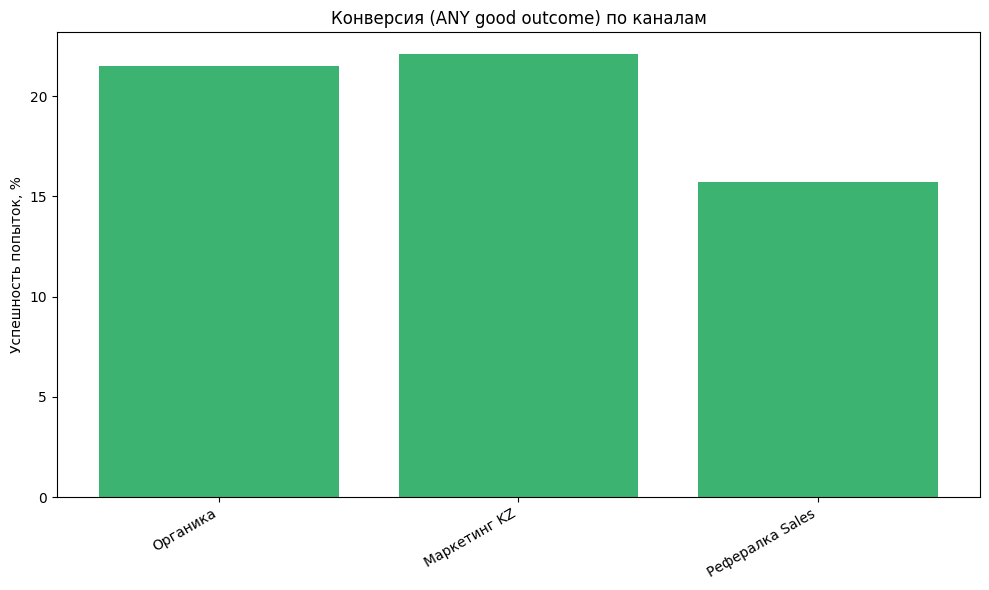

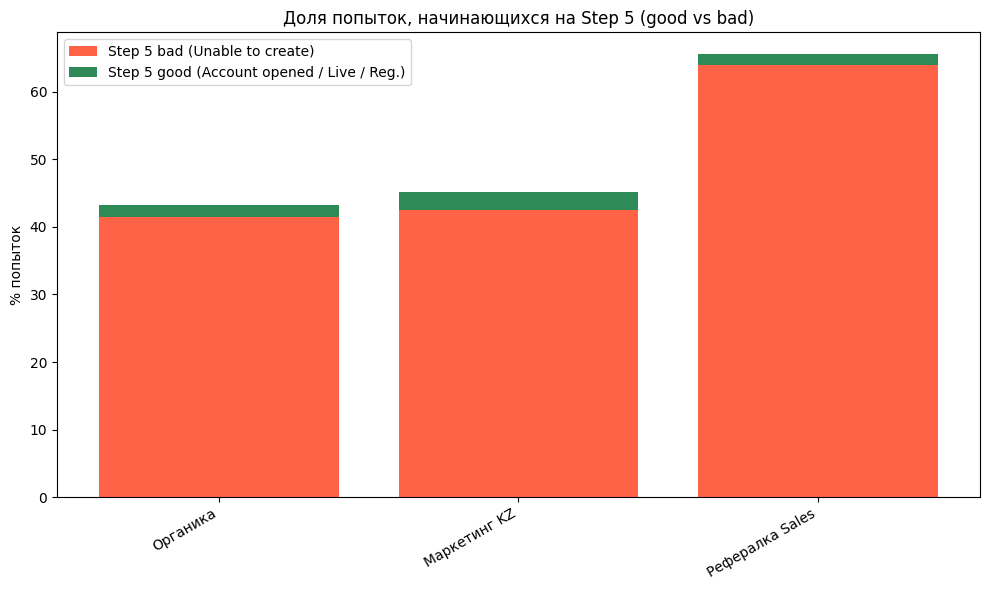

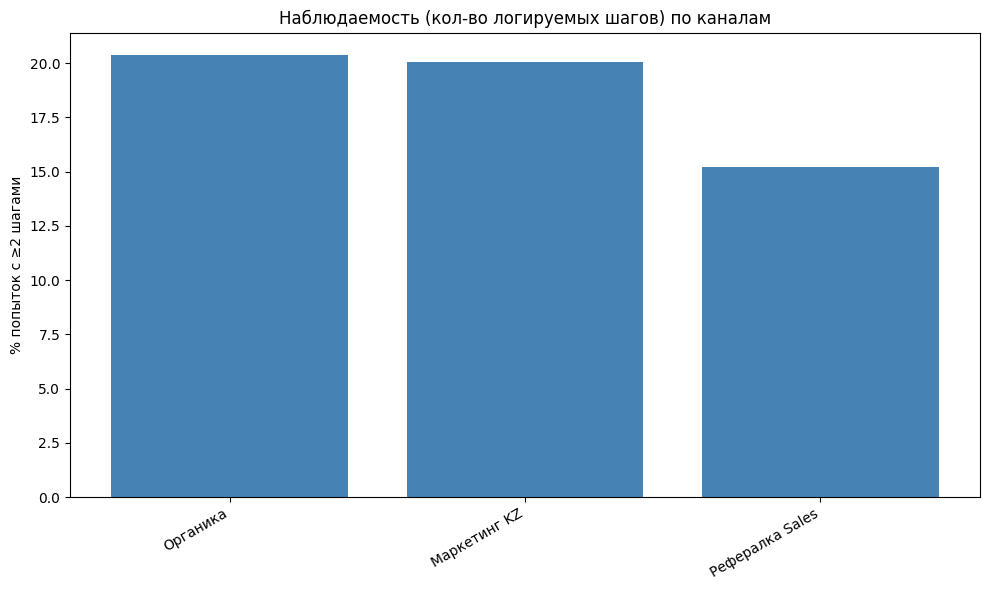

In [30]:
# --- 1) Attempt-level success rate (ANY good outcome) ---
att_plot = attempt_kpis_ch.copy().sort_values('n_attempts', ascending=False)
plt.figure(figsize=(10,6))
plt.bar(att_plot['Канал привлечения'], att_plot['success_rate_any']*100, color='mediumseagreen')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Успешность попыток, %')
plt.title('Конверсия (ANY good outcome) по каналам')
plt.tight_layout()
plt.show()

# --- 2) Step 5 entry: good vs bad shares (traffic quality) ---
entry_plot = entry5_by_ch.copy().sort_values('n_attempts', ascending=False)
x = np.arange(len(entry_plot))
plt.figure(figsize=(10,6))
plt.bar(x, entry_plot['entry5_bad_share']*100, label='Step 5 bad (Unable to create)', color='tomato')
plt.bar(x, entry_plot['entry5_good_share']*100,
        bottom=entry_plot['entry5_bad_share']*100,
        label='Step 5 good (Account opened / Live / Reg.)', color='seagreen')
plt.xticks(x, entry_plot['Канал привлечения'], rotation=30, ha='right')
plt.ylabel('% попыток')
plt.title('Доля попыток, начинающихся на Step 5 (good vs bad)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 3) Observability (≥2 distinct steps logged) ---
obs_plot = obs_by_ch.copy().sort_values('obs_share', ascending=False)
plt.figure(figsize=(10,6))
plt.bar(obs_plot['Канал привлечения'], obs_plot['obs_share']*100, color='steelblue')
plt.xticks(rotation=30, ha='right')
plt.ylabel('% попыток с ≥2 шагами')
plt.title('Наблюдаемость (кол-во логируемых шагов) по каналам')
plt.tight_layout()
plt.show()

In [31]:
import pandas as pd

# We already have:
# attempt_kpis_ch with 'success_rate_any'
# entry5_by_ch with 'entry5_bad_share'
# obs_by_ch with 'obs_share'

# Merge them into one table by channel
summary = (attempt_kpis_ch[['Канал привлечения','success_rate_any']]
           .merge(entry5_by_ch[['Канал привлечения','entry5_bad_share']], on='Канал привлечения')
           .merge(obs_by_ch[['Канал привлечения','obs_share']], on='Канал привлечения'))

# Format as percents
summary['% успешных попыток'] = (summary['success_rate_any']*100).round(1).astype(str) + ' %'
summary['% попыток сразу Step 5 (bad)'] = (summary['entry5_bad_share']*100).round(0).astype(int).astype(str) + ' %'
summary['Наблюдаемость ≥2 шагов'] = (summary['obs_share']*100).round(0).astype(int).astype(str) + ' %'

# Pick only the pretty columns and sort by attempts
summary_pretty = summary[['Канал привлечения',
                          '% успешных попыток',
                          '% попыток сразу Step 5 (bad)',
                          'Наблюдаемость ≥2 шагов']]

# Show
from IPython.display import display
display(summary_pretty)

,Канал привлечения,% успешных попыток,% попыток сразу Step 5 (bad),Наблюдаемость ≥2 шагов
0,Органика,21.5 %,41 %,20 %
1,Маркетинг KZ,22.1 %,42 %,20 %
2,Рефералка Sales,15.7 %,64 %,15 %


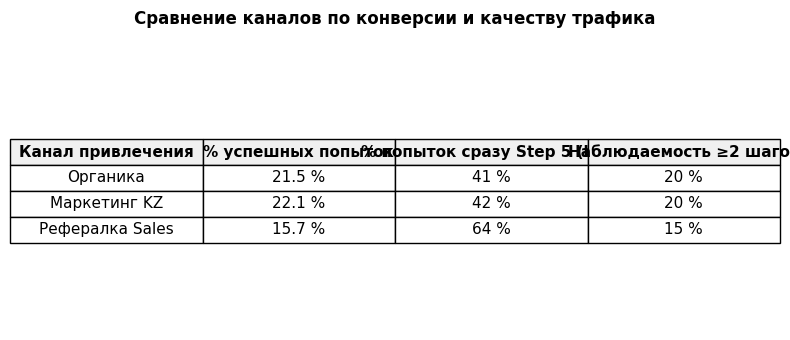

In [32]:
import matplotlib.pyplot as plt

# Assume summary_pretty is the DataFrame we built above
# It has columns: 'Канал привлечения', '% успешных попыток', '% попыток сразу Step 5 (bad)', 'Наблюдаемость ≥2 шагов'

fig, ax = plt.subplots(figsize=(8, 2 + 0.5*len(summary_pretty)))
ax.axis('off')

# Build cell text (including headers)
cell_text = []
for i in range(len(summary_pretty)):
    row = summary_pretty.iloc[i]
    cell_text.append(row.values)

# Create the table
table = ax.table(cellText=cell_text,
                 colLabels=summary_pretty.columns,
                 cellLoc='center',
                 loc='center')

# Style: column widths, font size, row heights
table.auto_set_font_size(False)
table.set_fontsize(11)

# Make header bold
for key, cell in table.get_celld().items():
    row, col = key
    if row == 0:  # header
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f0f0f0')

table.scale(1, 1.5)  # x- and y-scaling

plt.title('Сравнение каналов по конверсии и качеству трафика', fontsize=12, weight='bold', pad=20)
plt.tight_layout()
plt.show()

In [33]:
import numpy as np
import pandas as pd

# ===== 0) Мэппинг шагов и «терминалов» =====
STEP_EVENTS = {
    1: ['Account successfully created for user','Account setup completed successfully'],
    2: ['Initiated account registration','Account set up through a mobile device'],
    3: ['User session established','User profile status changed'],
    4: ['Chosen a pricing plan for the accoun'],
    5: ['Unable to create account','Account opened successfully','Switched to live environment',
        'Account registered under a personal name','Account created for a business or organization']
}
GOOD = {'Account opened successfully','Switched to live environment',
        'Account registered under a personal name','Account created for a business or organization'}
BAD  = {'Unable to create account'}

ALLOWED = set().union(*STEP_EVENTS.values())
name_to_step = {n:s for s, names in STEP_EVENTS.items() for n in names}

# ===== 1) Подготовка событий и попыток (векторно) =====
ev = events.loc[events['name'].isin(ALLOWED), ['user_id','name','date_mod']].copy()
ev['step_no'] = ev['name'].map(name_to_step).astype('Int8')
ev = ev.sort_values(['user_id','date_mod'], kind='mergesort')

# попытки
GAP_H = 24
ev['gap_h'] = ev.groupby('user_id', sort=False)['date_mod'].diff().dt.total_seconds().div(3600)
ev['is_terminal'] = ev['name'].isin(GOOD | BAD)
ev['prev_terminal'] = ev.groupby('user_id', sort=False)['is_terminal'].shift().fillna(False)
ev['new_attempt_flag'] = ev['step_no'].isin({1,2,3}) | ev['prev_terminal'] | (ev['gap_h'] > GAP_H)
ev['attempt'] = ev.groupby('user_id', sort=False)['new_attempt_flag'].cumsum().astype('int32')

# присоединим канал
attrs = meta[['id','Канал привлечения']].drop_duplicates('id')
ev = ev.merge(attrs, left_on='user_id', right_on='id', how='left').drop(columns=['id'])

# ===== 2) Итог по попыткам (чем закончилась, максимальный шаг, точка обрыва) =====
# earliest per step
step_first = (ev.groupby(['user_id','attempt','step_no'], sort=False)['date_mod']
                .min().unstack('step_no'))
attempts = (step_first
            .rename(columns={1:'s1',2:'s2',3:'s3',4:'s4',5:'s5'})
            .reset_index())

# outcome
good_ts = ev.loc[ev['name'].isin(GOOD)].groupby(['user_id','attempt'])['date_mod'].min()
bad_ts  = ev.loc[ev['name'].isin(BAD)].groupby(['user_id','attempt'])['date_mod'].min()
attempts = attempts.merge(good_ts.rename('good_ts'), on=['user_id','attempt'], how='left')
attempts = attempts.merge(bad_ts.rename('bad_ts'), on=['user_id','attempt'], how='left')
attempts['outcome'] = np.where(attempts['good_ts'].notna(),'success',
                        np.where(attempts['bad_ts'].notna(),'fail','none'))

# entry step & max step
attempts['entry_step'] = attempts[['s1','s2','s3','s4','s5']].notna().idxmax(axis=1).str[-1].astype('int8')
attempts['entry_step'] = attempts['entry_step'].where(attempts[['s1','s2','s3','s4','s5']].notna().any(axis=1), np.nan)

def max_step_row(r):
    for st in [5,4,3,2,1]:
        if pd.notna(r[f's{st}']):
            return st
    return np.nan

attempts['max_step_reached'] = attempts.apply(max_step_row, axis=1)

# точка обрыва (для неуспешных/без исхода): последний достигнутый шаг (<5)
attempts['drop_step'] = np.where(attempts['outcome'].isin(['fail','none']),
                                 np.where(attempts['max_step_reached']<5, attempts['max_step_reached'], 5),
                                 np.nan)

# канал
attempts = attempts.merge(
    ev.groupby(['user_id','attempt'], sort=False)['Канал привлечения'].first().rename('Канал привлечения').reset_index(),
    on=['user_id','attempt'], how='left'
)

# ===== 3) Повторы/зацикливания и «плохие» переходы =====
# последовательности шагов (без дублей по времени, но с учетом последовательности)
g = ev.sort_values(['user_id','attempt','date_mod'])
g = g[['user_id','attempt','Канал привлечения','step_no','name','date_mod']].copy()

# consecutive repeats (шаг -> тот же шаг подряд)
g['prev_step'] = g.groupby(['user_id','attempt'])['step_no'].shift()
g['repeat_flag'] = (g['step_no'] == g['prev_step'])

# транзакции шаг->шаг
g['next_step'] = g.groupby(['user_id','attempt'])['step_no'].shift(-1)
g['edge'] = list(zip(g['step_no'].values, g['next_step'].values))
# маркируем успех попытки, чтобы оценить success_rate по ребрам
att_success = attempts.set_index(['user_id','attempt'])['outcome'].eq('success')
g = g.merge(att_success.rename('attempt_success'), left_on=['user_id','attempt'], right_index=True, how='left')

# ===== 4) Агрегации по каналам: где обрывается и где зацикливается =====

# 4.1 Точки обрыва
drop_by_ch = (attempts[attempts['outcome'].isin(['fail','none'])]
              .groupby(['Канал привлечения','drop_step'])
              .size().rename('n_attempts').reset_index()
              .sort_values(['Канал привлечения','n_attempts'], ascending=[True,False]))

# 4.2 Доля повторов по шагам (зацикливание на одном шаге)
repeat_by_ch_step = (g.groupby(['Канал привлечения','step_no'])['repeat_flag']
                     .mean().rename('repeat_share').reset_index()
                     .sort_values(['Канал привлечения','repeat_share'], ascending=[True,False]))

# 4.3 «Плохие» ребра: частые переходы с низкой итоговой успешностью попытки
edges = g.dropna(subset=['next_step']).copy()
edge_stats_ch = (edges.groupby(['Канал привлечения','edge'])
                 .agg(n=('attempt_success','size'),
                      success_rate=('attempt_success','mean'))
                 .reset_index())
# выделим объемные и слабые
bad_edges_by_ch = edge_stats_ch[(edge_stats_ch['n']>=500) & (edge_stats_ch['success_rate']<=0.2)] \
                   .sort_values(['Канал привлечения','n'], ascending=[True, False])

# ===== 5) Вывод «топ проблем» по каналам =====
print("\n--- ТОЧКИ ОБРЫВА (fail/none): топ по каналам ---")
for ch in attempts['Канал привлечения'].dropna().unique():
    top_drop = drop_by_ch[drop_by_ch['Канал привлечения']==ch].head(5)
    print(f"\nКанал: {ch}")
    print(top_drop)

print("\n--- ЗАЦИКЛИВАНИЯ (повторы шагов): доля повторов по шагам ---")
for ch in attempts['Канал привлечения'].dropna().unique():
    rep = repeat_by_ch_step[repeat_by_ch_step['Канал привлечения']==ch].copy()
    rep['step_no'] = rep['step_no'].astype(int)
    print(f"\nКанал: {ch}")
    print(rep.sort_values('repeat_share', ascending=False).head(5))

print("\n--- ПЛОХИЕ РЕБРА (часто встречаются, но низкая итоговая успешность) ---")
for ch in attempts['Канал привлечения'].dropna().unique():
    bad = bad_edges_by_ch[bad_edges_by_ch['Канал привлечения']==ch].copy()
    if bad.empty:
        continue
    # красивый вид edge (s->t)
    bad['edge_str'] = bad['edge'].apply(lambda t: f"{int(t[0])}→{int(t[1])}")
    print(f"\nКанал: {ch}")
    print(bad[['edge_str','n','success_rate']].head(10))

/var/folders/b8/rcg993r57gn32qbmybxkp4280000gn/T/ipykernel_54368/1674405891.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ev['prev_terminal'] = ev.groupby('user_id', sort=False)['is_terminal'].shift().fillna(False)



--- ТОЧКИ ОБРЫВА (fail/none): топ по каналам ---

Канал: Органика
  Канал привлечения  drop_step  n_attempts
9          Органика        5.0      237474
6          Органика        2.0       86335
7          Органика        3.0       61067
5          Органика        1.0       58126
8          Органика        4.0         925

Канал: Рефералка Sales
   Канал привлечения  drop_step  n_attempts
14   Рефералка Sales        5.0       67310
12   Рефералка Sales        3.0       10523
10   Рефералка Sales        1.0        6227
11   Рефералка Sales        2.0        3163
13   Рефералка Sales        4.0         231

Канал: Маркетинг KZ
  Канал привлечения  drop_step  n_attempts
4      Маркетинг KZ        5.0      111496
1      Маркетинг KZ        2.0       39577
0      Маркетинг KZ        1.0       25990
2      Маркетинг KZ        3.0       24566
3      Маркетинг KZ        4.0         470

--- ЗАЦИКЛИВАНИЯ (повторы шагов): доля повторов по шагам ---

Канал: Органика
  Канал привлечения  step_no 

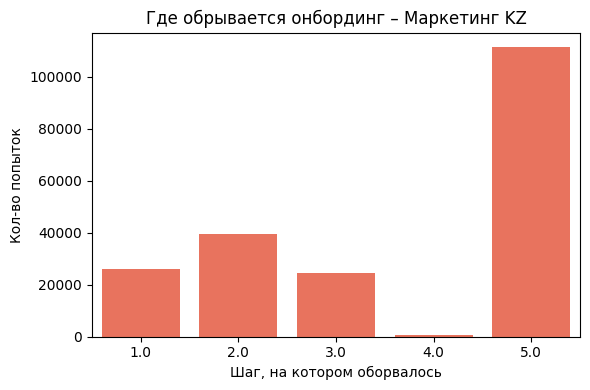

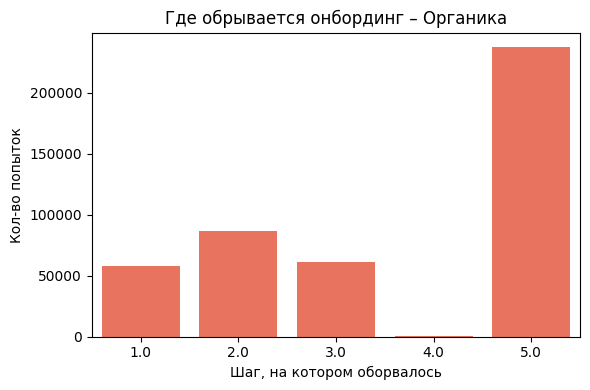

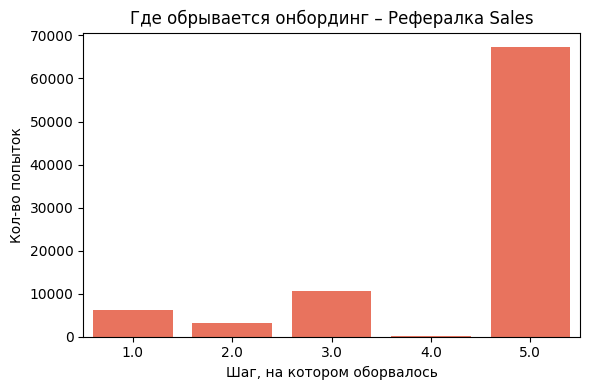

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# drop_by_ch уже посчитан
top_channels = drop_by_ch['Канал привлечения'].unique()

for ch in top_channels:
    sub = drop_by_ch[drop_by_ch['Канал привлечения']==ch]
    plt.figure(figsize=(6,4))
    sns.barplot(x='drop_step', y='n_attempts', data=sub, color='tomato')
    plt.title(f'Где обрывается онбординг – {ch}')
    plt.xlabel('Шаг, на котором оборвалось')
    plt.ylabel('Кол-во попыток')
    plt.tight_layout()
    plt.show()

In [35]:
# repeat_by_ch_step уже посчитан
pivot_rep = repeat_by_ch_step.pivot(index='step_no', columns='Канал привлечения', values='repeat_share')
plt.figure(figsize=(8,4))
sns.heatmap(pivot_rep*100, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Доля повторов шагов (%) по каналам')
plt.xlabel('Канал привлечения')
plt.ylabel('Номер шага')
plt.tight_layout()
plt.show()

TypeError: float() argument must be a string or a real number, not 'NAType'

<Figure size 800x400 with 0 Axes>

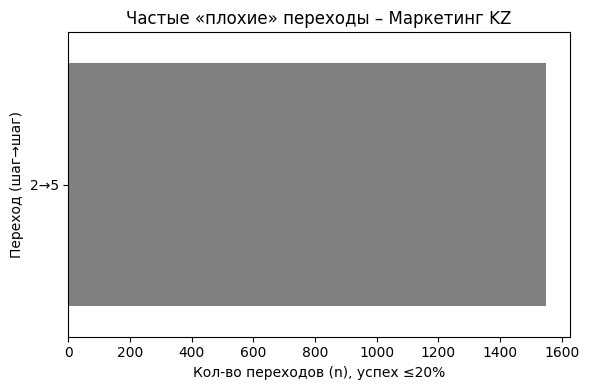

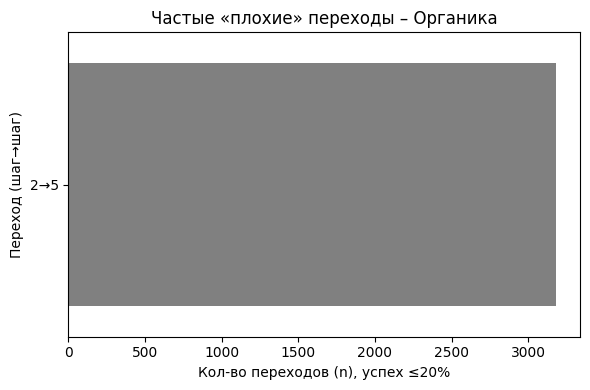

In [37]:
# bad_edges_by_ch уже посчитан
for ch in bad_edges_by_ch['Канал привлечения'].unique():
    sub = bad_edges_by_ch[bad_edges_by_ch['Канал привлечения']==ch].copy()
    sub['edge_str'] = sub['edge'].apply(lambda t: f'{int(t[0])}→{int(t[1])}')
    sub = sub.sort_values('n', ascending=False).head(5)
    plt.figure(figsize=(6,4))
    sns.barplot(y='edge_str', x='n', data=sub, color='gray')
    plt.title(f'Частые «плохие» переходы – {ch}')
    plt.xlabel('Кол-во переходов (n), успех ≤20%')
    plt.ylabel('Переход (шаг→шаг)')
    plt.tight_layout()
    plt.show()